## Click-Through Rate Prediction

### Overview

In this case, the steps for a click-through rate(CTR) prediction pipeline is shown. Dataset comes from a Kaggle competition which includes total of 26 columns of categorical features. These features are converted to numerical dat with one-hot-encoding(OEH). Also feature hushing is applied to reduce dimension of dataset. In terms of modelling, logistic regression with SGD is used and models are evaluated by “log-loss” method.

### Procedure

1. Data handling
 * Raw data is split into training, validation and test dataset
2. One-hot-encoding(Over 233K categories)
 * Generate OHE dictionary
 * Convert raw data to OHE dataset
3. Construct a logistic regression model with OHE dataset(Model1)
4. Reduce feature dimension via feature hashing(Over 3K categories)
5. Construct logistic regression models with hushed dataset
 * Logistic model with default parameters(Model2)
 * Logistic model with parameters determined by grid search(Model3)
6. Comparison between models.
 * OHE features model (Model1) vs hushed features model (Model2) 
 * Default param model (Model2) vs Grid searched params model (Model3)

In [1]:
import numpy as np
from pyspark.mllib.linalg import SparseVector
from pyspark.mllib.regression import LabeledPoint

### Raw data is split into training, validation and test dataset

In [2]:
rawData = (sc.textFile("dac_sample.txt").map(lambda x: x.replace('\t', ',')))

OneSample = rawData.take(1)
print OneSample


weights = [.8, .1, .1]
seed = 42
rawTrainData, rawValidationData, rawTestData = rawData.randomSplit(weights, seed)

#Cache each datasets as it is used repeatedly
rawTrainData.cache()
rawValidationData.cache()
rawTestData.cache()

nTrain = rawTrainData.count()
nVal = rawValidationData.count()
nTest = rawTestData.count()
print nTrain, nVal, nTest, nTrain + nVal + nTest

[u'0,1,1,5,0,1382,4,15,2,181,1,2,,2,68fd1e64,80e26c9b,fb936136,7b4723c4,25c83c98,7e0ccccf,de7995b8,1f89b562,a73ee510,a8cd5504,b2cb9c98,37c9c164,2824a5f6,1adce6ef,8ba8b39a,891b62e7,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,,3a171ecb,c5c50484,e8b83407,9727dd16']
79911 10075 10014 100000


### Apply one-hot-encoding(OHE) method

In [3]:
def createOneHotDict(inputData):
    OHEDict = (inputData
               .flatMap(lambda x: x)
               .distinct()
               .zipWithIndex()
               .collectAsMap())
    return OHEDict


def parsePoint(point):
    items = point.split(',')
    return [(i, item) for i, item in enumerate(items[1:])]
    
def oneHotEncoding(rawFeats, OHEDict, numOHEFeats):
    sizeList = [OHEDict[f] for f in rawFeats if f in OHEDict]
    sortedSizeList = sorted(sizeList)
    valueList = [1 for f in rawFeats if f in OHEDict ]
    return SparseVector(numOHEFeats, sortedSizeList, valueList)


def parseOHEPoint(point, OHEDict, numOHEFeats):
    parsedPoints = parsePoint(point)
    items = point.split(',')
    label = items[0]
    features = oneHotEncoding(parsedPoints, OHEDict, numOHEFeats)
    return LabeledPoint(label, features)

In [4]:
parsedFeat = rawTrainData.map(parsePoint)
ctrOHEDict = createOneHotDict(parsedFeat)
numCtrOHEFeats = len(ctrOHEDict.keys())


OHETrainData = rawTrainData.map(lambda point: parseOHEPoint(point, ctrOHEDict, numCtrOHEFeats)).cache()
OHEValidationData = rawValidationData.map(lambda point: parseOHEPoint(point, ctrOHEDict, numCtrOHEFeats)).cache()
OHETestData = rawTestData.map(lambda point: parseOHEPoint(point, ctrOHEDict, numCtrOHEFeats)).cache()

print ('Feature size after OHE:\n\tNumber of features = {0}'
       .format(numCtrOHEFeats))

print OHETrainData.take(1)

Feature size after OHE:
	Number of features = 233286
[LabeledPoint(0.0, (233286,[386,3077,6799,8264,8862,11800,12802,16125,17551,18566,29331,33132,39525,55794,61786,81396,82659,93573,96929,100677,109699,110646,112132,120260,128596,132397,132803,140620,160675,185498,190370,191146,195925,202664,204273,206055,222737,225958,229942],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]))]


### Construct a logistic regression model with OHE dataset(Model1)

In [5]:
from pyspark.mllib.classification import LogisticRegressionWithSGD

numIters = 100
stepSize = 1.0
regParam = 0.01
regType = 'l2'
includeIntercept = True

model0 = LogisticRegressionWithSGD.train(data = OHETrainData, 
                                         iterations = numIters, 
                                         step = stepSize, 
                                         regParam = regParam,
                                         regType = regType,
                                         intercept = includeIntercept)

In [6]:
#Compute loglos
from math import log, exp 

def computeLogLoss(p, y):
    epsilon = 10e-12
    if y == 1:
        return -log(epsilon + p) if p == 0 else -log(p)
    elif y == 0:
        return -log(1 - p + epsilon) if p == 1 else -log(1 - p)

def getP(x, w, intercept):
    rawPrediction = x.dot(w) + intercept

    # Bound the raw prediction value
    rawPrediction = min(rawPrediction, 20)
    rawPrediction = max(rawPrediction, -20)
    return 1.0 / (1.0 + exp(-rawPrediction))

def evaluateResults(model, data):
    return data.map(lambda x: computeLogLoss(getP(x.features, model.weights, model.intercept), x.label)).sum() / data.count()

In [7]:
logLossValLR0 = evaluateResults(model0, OHEValidationData)
print ('Validation Logloss for model1:\n\t = {0}'
       .format(logLossValLR0))

Validation Logloss for model1:
	 = 0.482516616442


In [8]:
### Plot ROC curve 

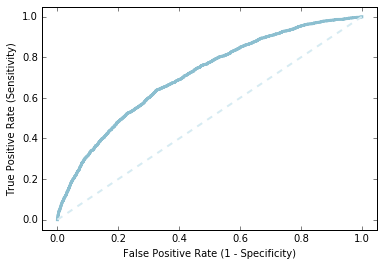

In [9]:
labelsAndScores = OHEValidationData.map(lambda lp: (lp.label, getP(lp.features, model0.weights, model0.intercept)))
labelsAndWeights = labelsAndScores.collect()
labelsAndWeights.sort(key=lambda (k, v): v, reverse=True)
labelsByWeight = np.array([k for (k, v) in labelsAndWeights])

length = labelsByWeight.size
truePositives = labelsByWeight.cumsum()
numPositive = truePositives[-1]
falsePositives = np.arange(1.0, length + 1, 1.) - truePositives

truePositiveRate = truePositives / numPositive
falsePositiveRate = falsePositives / (length - numPositive)

import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
ax = plt.subplot(111)

ax.set_xlim(-.05, 1.05), ax.set_ylim(-.05, 1.05)
ax.set_ylabel('True Positive Rate (Sensitivity)')
ax.set_xlabel('False Positive Rate (1 - Specificity)')
plt.plot(falsePositiveRate, truePositiveRate, color='#8cbfd0', linestyle='-', linewidth=3.)
plt.plot((0., 1.), (0., 1.), linestyle='--', color='#d6ebf2', linewidth=2.)

## Reduce feature dimension via feature hashing

In [10]:
from collections import defaultdict
import hashlib

def hashFunction(numBuckets, rawFeats, printMapping=False):
    mapping = {}
    for ind, category in rawFeats:
        featureString = category + str(ind)
        mapping[featureString] = int(int(hashlib.md5(featureString).hexdigest(), 16) % numBuckets)
    sparseFeatures = defaultdict(float)
    for bucket in mapping.values():
        sparseFeatures[bucket] += 1.0
    return dict(sparseFeatures)


def parseHashPoint(point, numBuckets):
    parsedPoints = parsePoint(point)
    items = point.split(',')
    label = items[0]
    features = hashFunction(numBuckets, parsedPoints, printMapping=False)
    return LabeledPoint(label, SparseVector(numBuckets, features))

numBucketsCTR = 2 ** 15
hashTrainData = rawTrainData.map(lambda x: parseHashPoint(x, numBucketsCTR))
hashTrainData.cache()
hashValidationData = rawValidationData.map(lambda x: parseHashPoint(x, numBucketsCTR))
hashValidationData.cache()
hashTestData = rawTestData.map(lambda x: parseHashPoint(x, numBucketsCTR))
hashTestData.cache()

print ('Feature size after hushing:\n\tNumber of features = {0}'
       .format(numBucketsCTR))

print hashTrainData.take(1)

Feature size after hushing:
	Number of features = 32768
[LabeledPoint(0.0, (32768,[1305,2883,3807,4814,4866,4913,6952,7117,9985,10316,11512,11722,12365,13893,14735,15816,16198,17761,19274,21604,22256,22563,22785,24855,25202,25533,25721,26487,26656,27668,28211,29152,29402,29873,30039,31484,32493,32708],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]))]


### Construct a logistic regression model with hushed dataset(Model2)

In [11]:
numIters = 100
stepSize = 1.0
regParam = 0.01
regType = 'l2'
includeIntercept = True

model1 = LogisticRegressionWithSGD.train(data = hashTrainData, 
                                         iterations = numIters, 
                                         step = stepSize, 
                                         regParam = regParam,
                                         regType = regType,
                                         intercept = includeIntercept)

logLossValLR1 = evaluateResults(model1, hashValidationData)
print ('Validation Logloss for model1:\n\t = {0}'
       .format(logLossValLR1))

Validation Logloss for model1:
	 = 0.482691122185


### Construct a logistic regression model with hushed dataset and grid searched parameters (Model3)

best parameters:
	Best Stepsize = 7.000
	Best Rarams = 0.000
1e-07 [[ 0.51910013  0.51910015  0.51910029  0.51910175  0.51911634  0.51926454]
 [ 0.48589729  0.4858974   0.48589847  0.48590921  0.48605802  0.48715278]
 [ 0.47476165  0.47476184  0.47476375  0.47478289  0.4750353   0.47731296]
 [ 0.46130496  0.46130542  0.46131004  0.46137622  0.46208485  0.46799094]
 [ 0.45587263  0.45587339  0.45588094  0.45600577  0.45715016  0.465792  ]
 [ 0.45268179  0.45268281  0.45270706  0.45286577  0.45438559  0.46488834]]


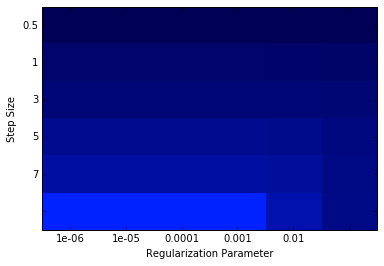

In [12]:
numIters = 500
stepSizes = [0.1, 0.5, 1, 3, 5, 7]
regParams = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
regType = 'l2'
includeIntercept = True


# Initialize variables using values from initial model training
bestModel = None
bestLogLoss = 1e10
logLoss = np.zeros((len(stepSizes),len(regParams)))

for i in xrange(len(stepSizes)):
    for j in xrange(len(regParams)):
        model = LogisticRegressionWithSGD.train(data = hashTrainData, 
                                                iterations = numIters, 
                                                step = stepSizes[i], 
                                                regParam = regParams[j],
                                                regType = regType,
                                                intercept = includeIntercept)
        
        logLoss[i, j] = evaluateResults(model, hashValidationData)
        
        if (logLoss[i, j] < bestLogLoss):
            bestModel = model
            bestStepsize = stepSizes[i]
            bestParams = regParams[j]
            bestLogLoss = logLoss[i,j]
            

print ('best parameters:\n\tBest Stepsize = {0:.3f}\n\tBest Rarams = {1:.3f}'
       .format(bestStepsize, bestParams))

print bestParams,logLoss

%matplotlib inline
from matplotlib.colors import LinearSegmentedColormap


numRows, numCols = len(stepSizes), len(regParams)
logLoss = np.array(logLoss)
logLoss.shape = (numRows, numCols)

fig = plt.figure()
ax = plt.subplot(111)


ax.set_xticklabels(regParams), ax.set_yticklabels(stepSizes)
ax.set_xlabel('Regularization Parameter'), ax.set_ylabel('Step Size')

colors = LinearSegmentedColormap.from_list('blue', ['#0022ff', '#000055'], gamma=.2)
image = plt.imshow(logLoss,interpolation='nearest', aspect='auto',
                    cmap = colors)
pass

### Logloss comparison between models

Fearture reduction has no impact on prediction of regression model. Parameters selected via grid search seems works well. 

In [13]:
logLossTestLR0 = evaluateResults(model0, OHETestData)
logLossTestLR1 = evaluateResults(model1, hashTestData)
logLossTestLRbest = evaluateResults(bestModel, hashTestData)

print ('OHECoding & Hashed Features Test Logloss:\n\tOHEModel = {0:.3f}\n\thashModel = {1:.3f}'
       .format(logLossTestLR0, logLossTestLR1))

print ('Hashed Features Validation Test Logloss:\n\tBaseModel = {0:.3f}\n\tBestModel = {1:.3f}'
       .format(logLossTestLR1, logLossTestLRbest))

OHECoding & Hashed Features Test Logloss:
	OHEModel = 0.490
	hashModel = 0.490
Hashed Features Validation Test Logloss:
	BaseModel = 0.490
	BestModel = 0.460
